In [142]:
# this code is not my code and copied out of other files in this repository
# here we're looking at the code in compute_transfer_function() which contains the crucial parts
import multiprocessing as mp
import numpy as np
import sys
import xarray as xr

### "main" of compute-transfer-function.py

In [145]:
# Parse command line inputs

input_filename = "/users/tms535/scratch/nonlinear_test_runs/test-for-transfer/test.out.nc"
#input_filename = "/users/tms535/scratch/nonlinear_test_runs/cyclone24/c24.out.nc" 
it_start = 0
it_end = 10

In [146]:
# Open Dataset
if "," in input_filename:
    input_filename_list = [f for f in input_filename.split(",")]
    ds = xr.open_mfdataset(input_filename_list)
else:
    ds = xr.open_dataset(input_filename)
# Remove un-used variables
required_vars = ["theta", "kx", "ky", "t", "density_t", "ntot_t", "phi_t"]
vars_to_delete = ["lambda"]  # un-used coords !CHANGED: "egrid" no longer printed, might be "negrid" now
for v in ds.data_vars:
    if v not in required_vars:
        vars_to_delete.append(v)
ds = ds.drop_vars(vars_to_delete)
ds = ds.drop_sel(t=ds["t"][it_end:])
ds = ds.drop_sel(t=ds["t"][:it_start])
# Load data for performance and to avoid concurrent read problems
ds.load()

<xarray.Dataset>
Dimensions:    (kx: 85, ky: 43, theta: 13, energy: 6, t: 10, ri: 2, species: 1)
Coordinates:
  * kx         (kx) float64 0.0 0.06283 0.1257 ... -0.1885 -0.1257 -0.06283
  * ky         (ky) float64 0.0 0.05 0.1 0.15 0.2 0.25 ... 1.9 1.95 2.0 2.05 2.1
  * theta      (theta) float64 -3.142 -2.618 -2.094 -1.571 ... 2.094 2.618 3.142
  * energy     (energy) float64 0.07939 1.562 4.921 6.666 8.544 12.54
  * t          (t) float64 0.0 0.3125 0.625 1.181 ... 3.056 4.231 6.169 10.62
Dimensions without coordinates: ri, species
Data variables:
    phi_t      (t, ky, kx, theta, ri) float64 0.0 0.0 ... -0.0003716 9.128e-05
    ntot_t     (t, species, ky, kx, theta, ri) float64 0.0 0.0 ... 9.051e-05
    density_t  (t, species, ky, kx, theta, ri) float64 0.0 0.0 ... 0.0001816
Attributes: (12/18)
    title:                      GS2 Simulation Data
    software_name:              GS2
    software_version:           8.1.1
    netcdf_version:             4.6.1 of Nov 27 2018 13:39:35 $
    date_created:               2022-06-28T22:09:07.896Z+01:00
    id:                         3E2A022E-4612-4B6D-BB2B-776F4A402832
    ...                         ...
    gs2_help:                   \n                                           ...
    input_file_extraction:      \n                                           ...
    simpledatio_info:           This datafile was constructed using simpledat...
    simpledatio_url:            http://github.com/edmundhighcock/simpledataio
    simpledatio_version:        1.0.0
    netcdf_url:                 http://www.unidata.ucar.edu/software/netcdf

In [147]:
ntheta = len(ds["theta"])
kx = np.fft.fftshift(ds["kx"].values)
nkx = len(kx)
ky = np.fft.fftshift(np.concatenate((ds["ky"].values, -ds["ky"].values[-1:0:-1])))
nky = len(ky)
ikx0 = np.argmin(np.abs(kx))
iky0 = np.argmin(np.abs(ky))
ikyt = iky0  # i.e. target is always zonal flows
t = ds["t"].values
nt = len(t)
z_hat_dot_k_cross_k_prime = np.reshape(
    np.reshape(kx, (1, nkx)) * np.reshape(ky, (nky, 1)), #tms535: outer product of kx and ky resulting 85x85 matrix
    (nky, 1, nkx), #tms535: reshaped into 85x1x85 tensor
)
k_factor_for_T_v = -np.reshape(
    np.reshape(kx, (1, nkx)) * np.reshape(kx, (nkx, 1)), #tms535: outer product of kx and kx resulting 85x85 matrix
    (1, nkx, nkx), #tms535: reshaped into 1x85x85 tensor
)

In [148]:
print(z_hat_dot_k_cross_k_prime.shape) 
print(k_factor_for_T_v.shape)
print((z_hat_dot_k_cross_k_prime*k_factor_for_T_v).shape) #shape for (nky,nkx,nkx)

(85, 1, 85)
(1, 85, 85)
(85, 85, 85)


In [149]:
def ri_to_complex(array_ri):
    array_complex = np.zeros(array_ri.shape[:-1], dtype=complex)
    array_complex.real = array_ri[..., 0]
    array_complex.imag = array_ri[..., 1]
    return array_complex

def move_first_axis_to_last(array_orig):
    # Roll first axis to last place, e.g. for improved cache performance
    # NB: Cannot use np.moveaxis(...) as the return value is just a view of the original
    array_new = np.zeros(
        np.concatenate((array_orig.shape[1:], [array_orig.shape[0]])),
        dtype=array_orig.dtype,
    )
    for i in range(array_orig.shape[0]):
        array_new[..., i] = array_orig[i, ...]
    return array_new

def make_full(array):
    # Assumes dimension order is ky, kx, t
    # For concatenated array:
    # - ky slice = -1:0:-1 so that we include non-zero kys in reverse order
    # - kx slice = -1::-1 so that we include all kxs in reverse order but this puts kx = 0
    #     to the end even though we still want it at the start, hence use of
    #     np.roll(..., 1, axis=1) so that kx = 0 is at ikx = 0
    # - np.conj(...) of the reversed and rolled array as the negative kys are the conjugate
    #     of the positive kys
    # - np.concatenate(..., axis=0) so that we concatenate in the ky direction
    return np.concatenate(
        (array, np.conj(np.roll(array[-1:0:-1, -1::-1, :], 1, axis=1))),
        axis=0,
    )


def compute_phi_m(phi, ikx0, iky0):
    # Pre-allocate array
    # NB: Cannot pre-allocate this variable in the global scope and re-use it here
    phi_m = np.zeros((nky, nkx, nkx, nt), dtype=complex)
    # Loop over target and source wavenumbers
    for ikys in range(nky):
        for ikxs in range(nkx):
            for ikxt in range(nkx):
                # Work out index of mediator
                ikxm = ikxt - ikxs + ikx0
                ikym = ikyt - ikys + iky0
                # Check mediator index exists
                if not (0 <= ikxm and ikxm < nkx and 0 <= ikym and ikym < nky):
                    # tms535: basically checks 0 <= ikym < nky and also 0 <= ikyx < nkx
                    # tms535: i.e. that the mediator indices do actually exist
                    # Just don't set a value to avoid unnecessary cache misses
                    continue #tms535: i.e. go to next loop
                # Store mediator value in mediator array
                phi_m[ikys, ikxs, ikxt, :] = phi[ikym, ikxm, :]
    # Return output array
    return phi_m

In [150]:
#skip parallelisation for all theta and wrapper and look at
# compute_net_transfer_this_theta() which prepares data for compute_net_transfer()

i_theta = 0
ntot = np.array(ds["ntot_t"][:, 0, :, :, i_theta, :])
density = np.array(ds["density_t"][:, 0, :, :, i_theta, :])
phi = np.array(ds["phi_t"][:, :, :, i_theta, :])

print("1",phi.shape)

# Convert ri dimension to complex dtype
ntot = ri_to_complex(ntot)
density = ri_to_complex(density)
phi = ri_to_complex(phi)

print("2",phi.shape)

# Move t axis to last position for improved cache performance
ntot = move_first_axis_to_last(ntot)
density = move_first_axis_to_last(density)
phi = move_first_axis_to_last(phi)

print("3",phi.shape)

# Make full versions of arrays to simplify indexing, 
# i.e. tms535: extent y-axis in the same way as was done for ky from 43 to 85 by mirroring to negative values
ntot = make_full(ntot)
density = make_full(density)
phi = make_full(phi)

print("4",phi.shape)

# Pre-shift arrays so that indexing works correctly
# align indexing of phi,ntot,density with indexing of kx and ky of [-n,..,0,..,n]
ntot = np.fft.fftshift(ntot, axes=(0, 1))
density = np.fft.fftshift(density, axes=(0, 1))
phi = np.fft.fftshift(phi, axes=(0, 1))

print("5",phi.shape)

# Pre-compute complex conjugate array
# tms535: at target zonal flow, i.e. take ky axis away already for this one
ntot_star = np.conj(ntot[ikyt, ...])
density_star = np.conj(density[ikyt, ...])
phi_star = np.conj(phi[ikyt, ...])

print("6",phi.shape)
print("6",phi_star.shape)

# Pre-prepare array of mediators for performance
phi_m = compute_phi_m(phi, ikx0, iky0)
# Compute transfer and return

1 (10, 43, 85, 2)
2 (10, 43, 85)
3 (43, 85, 10)
4 (85, 85, 10)
5 (85, 85, 10)
6 (85, 85, 10)
6 (85, 10)


In [151]:
phi_m.shape 
#shape (nky, nkx, nkx, nt) for kys, kxs, kxt, t as kyt = 0 = ZF fixed (kx order seen from comput_phi_m function)
#i.e. knows the phi at mediator index for each kys,kxs,kxt and t

(85, 85, 85, 10)

In [152]:
def compute_time_average(field):
    "Computes the time average of an N-D field assuming time is the last axis"
    if len(t) == 1:
        time_average = field[..., 0]
    else:
        time_average = (
            np.trapz(
                field,
                t,
            )
            / (t[-1] - t[0])
        )
    return time_average

In [153]:
# inside compute_net_transfer()
T_v = (
    2
    * z_hat_dot_k_cross_k_prime
    * k_factor_for_T_v
    * compute_time_average(
        (
            np.reshape(phi_star, (1, 1, nkx, nt))
            * phi_m
            * np.reshape(phi, (nky, nkx, 1, nt))
        ).real
    )
)

T_n = (
    2
    * z_hat_dot_k_cross_k_prime
    * compute_time_average(
        (
            np.reshape(ntot_star, (1, 1, nkx, nt))
            * phi_m
            * np.reshape(ntot, (nky, nkx, 1, nt))
        ).real
    )
)

T_d = (
    2
    * z_hat_dot_k_cross_k_prime
    * compute_time_average(
        (
            np.reshape(density_star, (1, 1, nkx, nt))
            * phi_m
            * np.reshape(density, (nky, nkx, 1, nt))
        ).real
    )
)

In [154]:
T_v.shape 
#can be seen from above reshaps that shape is for (nky,nkx,nkx) 
#for (kys,kxs,kxt) as can be seen from compute_phi_m final indexing

(85, 85, 85)

In [155]:
import matplotlib.pyplot as plt

In [156]:
plt.plot(kx,np.sum(T_v,axis=(0,1))) #(kys,kxs,kxt)
plt.title("T_v summed along kys and kxs against kxs to find strongest x-target-mode")

Text(0.5,1,'T_v summed along kys and kxs against kxs to find strongest x-target-mode')

In [157]:
#strongest kxt
np.argmax(np.sum(T_v,axis=(0,1)))

54

In [161]:
# i.e. radial mode number +/- 12 with wavenumber value
kx[54], kx[42], kx[30]

(0.7539822368615504, 0.0, -0.7539822368615504)

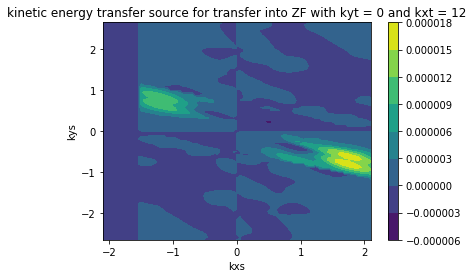

In [162]:
plot_ikxt = 54
plt.contourf(ky,kx,T_v[:,:,plot_ikxt]) # (kys,kxs,kxt)
plt.ylabel("kys")
plt.xlabel("kxs")
plt.title("kinetic energy transfer source for transfer into ZF with kyt = 0 and kxt = 12")
plt.colorbar()
plt.show()

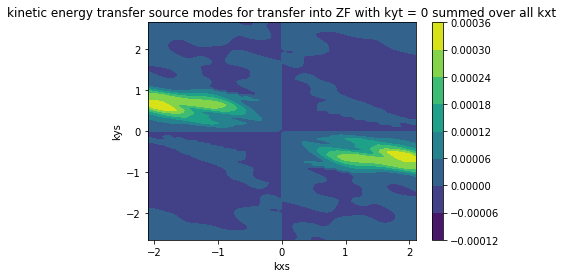

In [163]:
plt.contourf(ky,kx,np.sum(T_v,axis=2)) # (kys,kxs,kxt)
plt.ylabel("kys")
plt.xlabel("kxs")
plt.title("kinetic energy transfer source modes for transfer into ZF with kyt = 0 summed over all kxt")
plt.colorbar()
plt.show()

-> run this on longer shots and compare with "zonal_tranfer" diagnostic in gs2